# Plant Disease Identification

In this Jupyter Notebook, we are going to build a model to predict plant diseases. The dataset used can be found at: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset

# Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os

import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from keras.layers import Dense, Flatten
from keras.models import Model
import scipy.ndimage


In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


# Data Overview

In [3]:
train_data = "../data/raw/plant_diseases_data/train"
valid_data = "../data/raw/plant_diseases_data/valid"

In [4]:
diseases = os.listdir(train_data)
#printing the disease names 
print(diseases)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',

In [5]:
#  Printing count diseases
print(f"Number of diseases : {len(diseases)} ")

Number of diseases : 38 


In [6]:
#finding number of unique diseases and uniqure plants
plants = []
number_of_diseases = 0
for plant in diseases:
    plant_name,disease = plant.split("___")
    
    if plant_name not in plants:
        plants.append(plant_name)
    
    if disease != "healthy":
        number_of_diseases +=1
        
#Print the count of unique plants
print(f"Number of Plants:{len(plants)}")

#Print unique plant names
print(f"Unique Plant Names:{plants}")

#Print the count of diseases
print(f"Number of diseases : {number_of_diseases}")



Number of Plants:14
Unique Plant Names:['Apple', 'Blueberry', 'Cherry_(including_sour)', 'Corn_(maize)', 'Grape', 'Orange', 'Peach', 'Pepper,_bell', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']
Number of diseases : 26


In [7]:
#Number of images for each disease using a dictionary comprehension
number_of_images = {disease: len(os.listdir(os.path.join(train_data,disease))) for disease in diseases}

#Convering the nums dictionary to a pandas DataFrame
img_per_class = pd.DataFrame(list(number_of_images.items()), columns = ["Disease Name", "No.of Images"])

#Display the DataFrame
img_per_class

,Disease Name,No.of Images
0,Apple___Apple_scab,2016
1,Apple___Black_rot,1987
2,Apple___Cedar_apple_rust,1760
3,Apple___healthy,2008
4,Blueberry___healthy,1816
5,Cherry_(including_sour)___healthy,1826
6,Cherry_(including_sour)___Powdery_mildew,1683
7,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,1642
8,Corn_(maize)___Common_rust_,1907
9,Corn_(maize)___healthy,1859


# Data Preprocessing

In [8]:
train_datagenerator = ImageDataGenerator(zoom_range = 0.5, shear_range = 0.3, horizontal_flip = True, preprocessing_function = preprocess_input) 
valid_datagenerator = ImageDataGenerator(preprocessing_function = preprocess_input)

In [9]:
train = train_datagenerator.flow_from_directory(directory = "../data/raw/plant_diseases_data/train", target_size = (256,256), batch_size = 32)
valid =  valid_datagenerator.flow_from_directory(directory = "../data/raw/plant_diseases_data/valid", target_size = (256,256), batch_size = 32)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [10]:
t_img, label = train.next()
v_img, label = valid.next()

In [11]:
# preprocessing 

In [12]:
def plotimage(img_arr, label):
    for img, lbl in zip(img_arr, label):
        plt.figure(figsize = (5,5))
        plt.imshow(img)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


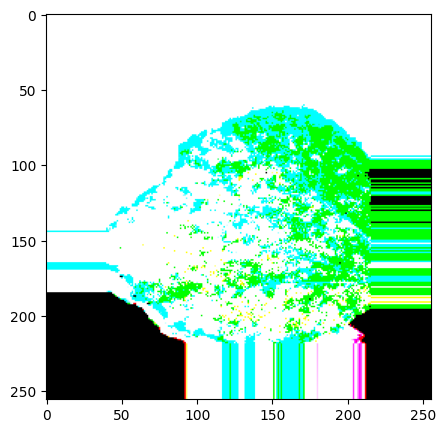

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


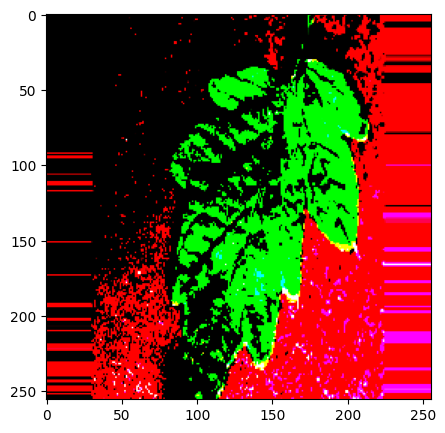

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


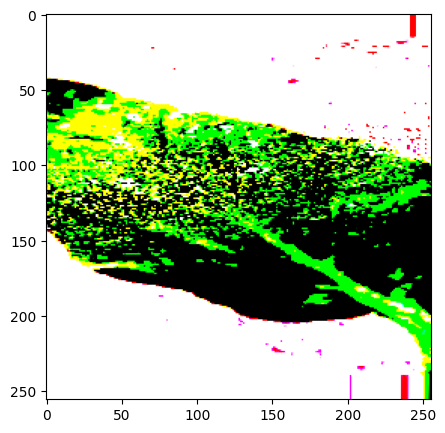

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


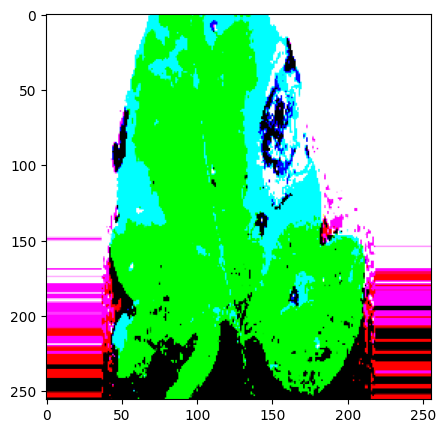

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


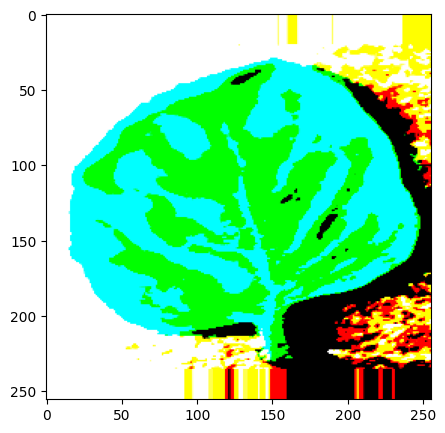

In [13]:
plotimage(t_img[:5], label[:5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


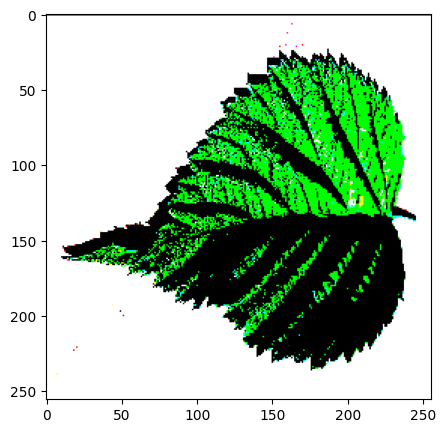

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


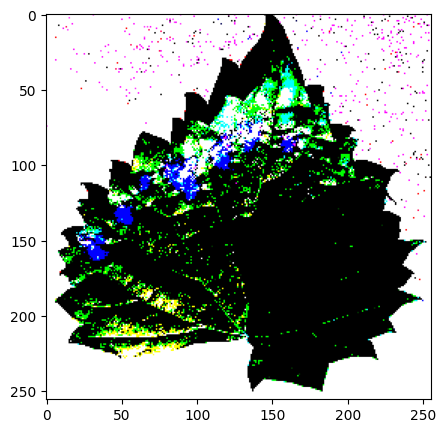

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


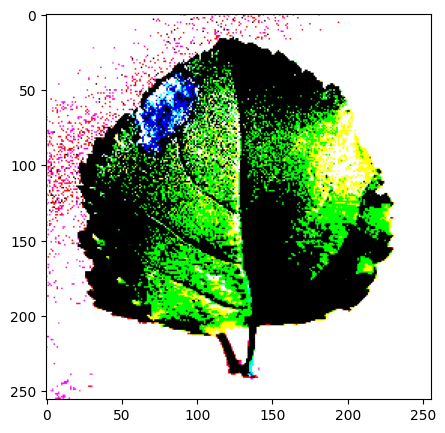

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


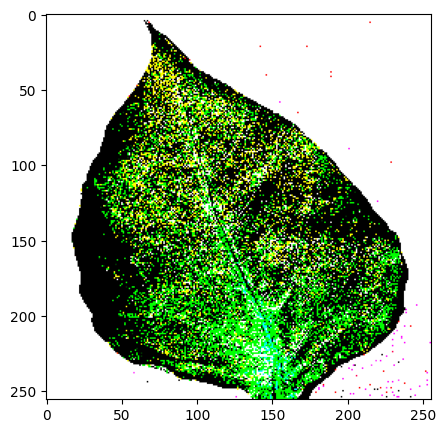

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


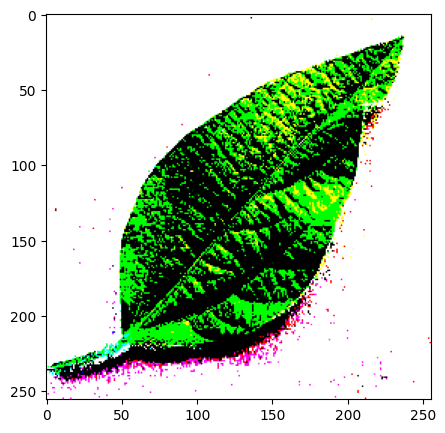

In [14]:
plotimage(v_img[:5], label[:5])

# Model Building

In [15]:
base_model = VGG19(input_shape = (256,256,3), include_top = False)

In [16]:
for layer in base_model.layers:
    layer.trainable = False

In [17]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [18]:
X = Flatten()(base_model.output)

X = Dense(units = 38, activation = "softmax")(X)

#creating model
model = Model(base_model.input, X)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

# Early stopping and Model Check point

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

#early stopping
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 3, verbose = 1)

#model checkpoint
model_checkpoint = ModelCheckpoint(filepath = "best_model.h5",monitor = 'val_accuracy', min_delta = 0.01, patience = 3, verbose = 1, save_best_only = True)

callback = [early_stopping, model_checkpoint]

In [21]:
model.compile(optimizer = "adam", loss = keras.losses.categorical_crossentropy, metrics = ["accuracy"])

In [22]:
history = model.fit_generator(train, 
                              steps_per_epoch = 16, 
                              epochs = 50, 
                              verbose = 1, 
                              callbacks = callback, 
                              validation_data = valid,
                              validation_steps = 16)

C:\Users\91939\AppData\Local\Temp\ipykernel_6156\2972944868.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train,


Epoch 1/50


16/16 [==============================] - ETA: 0s - loss: 25.8759 - accuracy: 0.1875
Epoch 1: val_accuracy improved from -inf to 0.43359, saving model to best_model.h5


C:\Users\91939\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 243s 16s/step - loss: 25.8759 - accuracy: 0.1875 - val_loss: 15.7888 - val_accuracy: 0.4336
Epoch 2/50
 4/16 [======>.......................] - ETA: 1:30 - loss: 17.4090 - accuracy: 0.4062

KeyboardInterrupt: 

In [ ]:
h  = history.history
h.keys()

In [ ]:
plt.plot(h["accuracy"])
plt.plot(h["val_accuracy"], c = "red")
plt.title("acc vs v-acc")
plt.show()

In [ ]:
plt.plot(h["loss"])
plt.plot(h["val_loss"], c = "red")
plt.title("loss vs v-loss")
plt.show()

In [ ]:
#Loading Model

In [ ]:
from keras.models import load_model
model = load_model("best_model.h5")

In [ ]:
# Model evaluation

In [ ]:
acc = model.evaluate(valid)[1]

print(f"The accuracy of model is : {acc*100}%")

In [ ]:
#prediction

In [ ]:
ref = dict(zip(train.class_indices.values(), list(train.class_indices.keys())))


In [ ]:
def prediction(path):
    img = load_img(path, target_size=(256, 256))
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels
    plt.show()

    i = img_to_array(img)
    im = preprocess_input(i)
    img = np.expand_dims(im, axis=0)

    # Suppress the progress output by setting verbose to 0
    pred = np.argmax(model.predict(img, verbose=0))
    
    return ref[pred]
    
    #print(f"The image belongs to {ref[pred]}")

In [ ]:
import openpyxl

In [ ]:
df = pd.read_excel("../data/raw/plant_diseases_data/disease_preventionlist.xlsx")
# Set the index to a column that uniquely identifies each row (e.g., 'Disease Name')
df.set_index('Diseases', inplace=True, drop=True)

In [ ]:
df.tail()

In [ ]:
df.head()

In [ ]:
# Assuming your DataFrame is named df

# Specify the disease you are interested in
target_disease = 'Apple___Apple_scab'  # Replace with the actual disease name

# Access the "Cause" and "Prevention measures" for the specified disease
cause = df.loc[target_disease, 'Cause']
prevention_measures = df.loc[target_disease, 'Prevention measures']

# Print the results
print(f"Cause of {target_disease}: {cause}")
print(f"Prevention measures for {target_disease}: {prevention_measures}")


In [ ]:
import openpyxl
from openpyxl.styles import Font

# Load the Excel file
workbook = openpyxl.load_workbook("C:\Users\91939\Desktop\Projects\agri-innovative\data\raw\plant_diseases_data\disease_preventionlist.xlsx")

# Specify the sheet name
sheet_name = 'Sheet1'

# Specify the target disease
target_disease = 'Apple___Apple_scab'

# Access the cell for "Cause" and "Prevention measures" for the specified disease
cause_cell = workbook[sheet_name].cell(row=workbook[sheet_name].find(target_disease).row, column=workbook[sheet_name].column_dimensions['Cause'].index)
prevention_measures_cell = workbook[sheet_name].cell(row=workbook[sheet_name].find(target_disease).row, column=workbook[sheet_name].column_dimensions['Prevention measures'].index)

# Extract the data and font color
cause = cause_cell.value
cause_color = cause_cell.font.color.rgb if cause_cell.font.color else None

prevention_measures = prevention_measures_cell.value
prevention_measures_color = prevention_measures_cell.font.color.rgb if prevention_measures_cell.font.color else None

# Print the results
print(f"Cause of {target_disease}: {cause} (Font color: {cause_color})")
print(f"Prevention measures for {target_disease}: {prevention_measures} (Font color: {prevention_measures_color})")


In [ ]:
path = "../data/raw/plant_diseases_data/test/AppleScab2.jpg"
res1 = prediction(path)
print(res1)


In [ ]:
# Assuming your DataFrame is named df

# Specify the disease you are interested in
target_disease = res1  # Replace with the actual disease name

# Access the "Cause" and "Prevention measures" for the specified disease
cause = df.loc[target_disease, 'Cause']
prevention_measures = df.loc[target_disease, 'Prevention measures']

# Print the results
print(f"Cause of {target_disease}: {cause}")
print(f"Prevention measures for {target_disease}: {prevention_measures}")
